### ***Default Estimator and WoE Binning***

#### ***Construct a Default Estimator (RFMS Score)***

*First, we need to calculate an RFMS score for each user. We’ll use the following metrics:*

- ***Recency***: *We will take the maximum Transaction_Year (or date) for each customer.* 
- ***Frequency***: *Count the number of transactions (Transaction_Count) per customer.*
- ***Monetary***: *Sum or average of transaction amounts (Total_Transaction_Amount or Average_Transaction_Amount).* 
- ***Stability*** : *Standard deviation of the transaction amounts (Std_Deviation_Transaction_Amount).*

In [1]:
## import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')


In [2]:
## import the one hot encoded data

df = pd.read_csv('../data/encoded_data.csv')
df.head()

,CustomerId,ProviderId,ChannelId,Amount,Value,PricingStrategy,FraudResult,Transaction_Hour,Transaction_Day,Transaction_Month,...,Transaction_Count,Std_Deviation_Transaction_Value,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill
0,4406,6,3,1000.0,1000.0,2,0,2,15,11,...,119,2073.975141,0,0,0,0,0,0,0,0
1,4406,4,2,-20.0,20.0,2,0,2,15,11,...,119,2073.975141,0,1,0,0,0,0,0,0
2,4683,6,3,500.0,500.0,2,0,2,15,11,...,2,0.000000,0,0,0,0,0,0,0,0
3,988,1,3,1000.0,1000.0,2,0,3,15,11,...,38,3613.003504,0,0,0,0,0,0,0,1
4,988,4,2,-644.0,644.0,2,0,3,15,11,...,38,3613.003504,0,1,0,0,0,0,0,0


In [3]:
## Drop unwanted columns

df.drop(columns=['Amount','PricingStrategy','FraudResult','ProviderId','ChannelId','ProductCategory_transport',
                 'ProductCategory_tv', 'ProductCategory_utility_bill','ProductCategory_data_bundles', 
                 'ProductCategory_financial_services', 'ProductCategory_movies', 'ProductCategory_other','ProductCategory_ticket'], inplace=True)

In [4]:
## Data types
df.dtypes

CustomerId                           int64
Value                              float64
Transaction_Hour                     int64
Transaction_Day                      int64
Transaction_Month                    int64
Transaction_Year                     int64
Total_Transaction_Value            float64
Average_Transaction_Value          float64
Transaction_Count                    int64
Std_Deviation_Transaction_Value    float64
dtype: object

In [5]:
## Combine Year, Month and Date features to calculate recency
# Combine Year, Month, and Day features to create a Date column
df['Date'] = pd.to_datetime(
    dict(year=df['Transaction_Year'], month=df['Transaction_Month'], day=df['Transaction_Day'])
)

## Calculate Recency as
df['Recency'] = (df['Date'].max() - df['Date']).dt.days

In [6]:
df['Date'].max()

Timestamp('2019-02-13 00:00:00')

In [7]:
### Calculate Frequency, Monetary and Stability
df['Frequency'] = df['Transaction_Count']
df['Monetary'] = df['Total_Transaction_Value']
df['Stability'] = df['Std_Deviation_Transaction_Value']

In [8]:
# Normalize RFMS components to bring them to the same scale
df['Recency'] = (df['Recency'] - df['Recency'].min()) / (df['Recency'].max() - df['Recency'].min())
df['Frequency'] = (df['Frequency'] - df['Frequency'].min()) / (df['Frequency'].max() - df['Frequency'].min())
df['Monetary'] = (df['Monetary'] - df['Monetary'].min()) / (df['Monetary'].max() - df['Monetary'].min())
df['Stability'] = (df['Stability'] - df['Stability'].min()) / (df['Stability'].max() - df['Stability'].min())

In [9]:
# Compute RFMS score (simple average of components)
df['RFMS_Score'] = (df['Recency'] + df['Frequency'] + df['Monetary'] + df['Stability']) / 4
df['RFMS_Score']

0        0.333282
1        0.333282
2        0.250096
3        0.377311
4        0.377311
           ...   
95657    0.110781
95658    0.083037
95659    0.083037
95660    0.158039
95661    0.158039
Name: RFMS_Score, Length: 95662, dtype: float64

In [10]:
## Let's use KMeans Clustering to assign labels to customers as Good and Bad

# Apply K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[['RFMS_Score']])

  File "d:\Personal Files\KIAM Notebooks\KIAM-Week6\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Program Files\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Program Files\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\Python310\lib\subprocess.py", line 1435, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


In [11]:
## Find Cluster centers
cluster_means = kmeans.cluster_centers_.flatten()
good_cluster = np.argmax(cluster_means)  # The cluster with the lower score (better RFMS)
df['Customer_Type'] = df['Cluster'].map({good_cluster: 'Good', 1 - good_cluster: 'Bad'})

In [12]:
df.head()

,CustomerId,Value,Transaction_Hour,Transaction_Day,Transaction_Month,Transaction_Year,Total_Transaction_Value,Average_Transaction_Value,Transaction_Count,Std_Deviation_Transaction_Value,Date,Recency,Frequency,Monetary,Stability,RFMS_Score,Cluster,Customer_Type
0,4406,1000.0,2,15,11,2018,184847.0,1553.336134,119,2073.975141,2018-11-15,1.0,0.028851,0.026998,0.277278,0.333282,0,Good
1,4406,20.0,2,15,11,2018,184847.0,1553.336134,119,2073.975141,2018-11-15,1.0,0.028851,0.026998,0.277278,0.333282,0,Good
2,4683,500.0,2,15,11,2018,1000.0,500.000000,2,0.000000,2018-11-15,1.0,0.000244,0.000139,0.000000,0.250096,1,Bad
3,988,1000.0,3,15,11,2018,117523.0,3092.710526,38,3613.003504,2018-11-15,1.0,0.009046,0.017162,0.483036,0.377311,0,Good
4,988,644.0,3,15,11,2018,117523.0,3092.710526,38,3613.003504,2018-11-15,1.0,0.009046,0.017162,0.483036,0.377311,0,Good


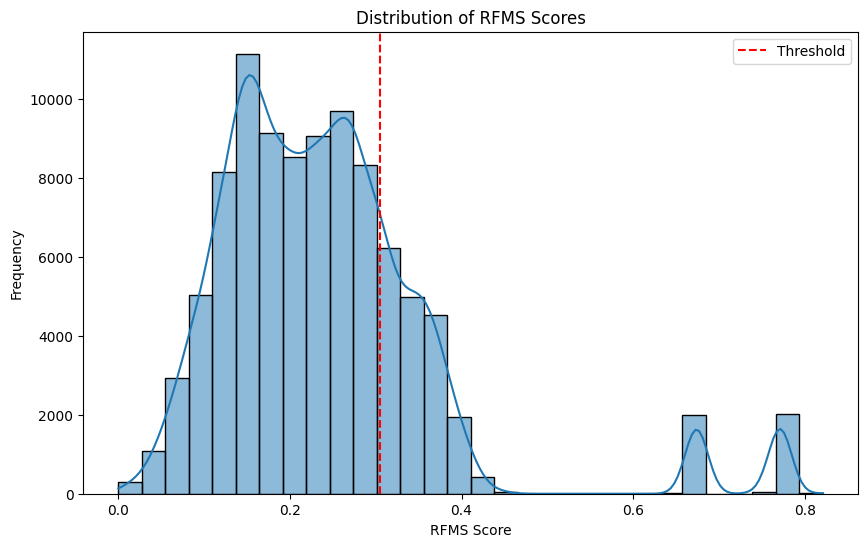

In [13]:
# Plot RFMS Score distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['RFMS_Score'], bins=30, kde=True)
plt.title('Distribution of RFMS Scores')
plt.xlabel('RFMS Score')
plt.ylabel('Frequency')
plt.axvline(x=np.mean(cluster_means), color='red', linestyle='--', label='Threshold')
plt.legend()
plt.show()

### ***OBSERVATION***

*The ***Threshold line*** represents the boundary that separates the "Good" customers from the "Bad" ones based on their ***RFMS score***. The RFMS score is a combination of ***Recency***, ***Frequency***, and ***Monetary*** metrics that help to assess customer behavior. By calculating the ***mean of the cluster centers*** using `np.mean(cluster_means)`, we establish a clear demarcation for classifying customers.*

*In this case, the computed threshold value is ***0.305***. This value serves as the cutoff point:*
- ***Customers with RFMS scores above 0.305*** *are considered ***Good*** (higher engagement or more recent activity).*
- ***Customers with RFMS scores below 0.305*** *are classified as ***Bad*** (lower engagement or less recent activity).*

#### ***Weight of Evidence and Information Value***

*WoE binning helps transform continuous or categorical variables for logistic regression or other models. The formula for WoE is:*

![alt text](image.png)

*We will apply WoE binning to our numerical features (Monetary, Frequency, etc.).*




In [14]:
import scorecardpy as sc
from monotonic_binning.monotonic_woe_binning import Binning

In [15]:
## Compute Monotonic bins for all features

var = df.drop(['CustomerId','Customer_Type','Date','Total_Transaction_Value', 
                'Transaction_Count', 'Std_Deviation_Transaction_Value','Cluster'], axis=1).columns
y_var = df['Cluster']

def woe_num(x, y):
  bin_object = Binning(y, n_threshold = 50, y_threshold = 10, p_threshold = 0.35, sign=False)
  global breaks
  breaks = {}
  for i in x:
    bin_object.fit(df[[y, i]])
    breaks[i] = (bin_object.bins[1:-1].tolist())
  return breaks

In [16]:
## view Bins for all features
woe_num(var, 'Cluster')

{'Value': [1020.0, 12050.0],
 'Transaction_Hour': [17.0, 19.0, 20.0, 21.0, 23.0],
 'Transaction_Day': [8.0, 24.0, 30.0, 31.0],
 'Transaction_Month': [12.0],
 'Transaction_Year': [2018.0, 2019.0],
 'Average_Transaction_Value': [606.3342925659473,
  6310.25641025641,
  6766.666666666667,
  7163.04347826087,
  7217.368421052632,
  7729.166666666667,
  8750.0,
  12000.0],
 'Recency': [1.0],
 'Frequency': [1.0],
 'Monetary': [1.0],
 'Stability': [1.0],
 'RFMS_Score': [0.8212507432918186]}

In [17]:
## Drop columns
df.drop(['CustomerId','Customer_Type','Date','Total_Transaction_Value', 
                'Transaction_Count', 'Std_Deviation_Transaction_Value'], axis=1, inplace=True)

In [18]:
## Create Adjusted Bins
bins_adj = sc.woebin(df, 'Cluster', breaks_list= breaks, positive = 'cluster|0') # change positive to adjust WOE to ln(GOOD / BAD)

[INFO] creating woe binning ...


In [19]:
import pickle

# Save WOE bins to a file
with open('woe_bins.pkl', 'wb') as file:
    pickle.dump(bins_adj, file)


{'Value': <Figure size 640x480 with 2 Axes>,
 'Recency': <Figure size 640x480 with 2 Axes>,
 'Transaction_Day': <Figure size 640x480 with 2 Axes>,
 'Transaction_Hour': <Figure size 640x480 with 2 Axes>,
 'Stability': <Figure size 640x480 with 2 Axes>,
 'Monetary': <Figure size 640x480 with 2 Axes>,
 'Average_Transaction_Value': <Figure size 640x480 with 2 Axes>,
 'Frequency': <Figure size 640x480 with 2 Axes>,
 'Transaction_Year': <Figure size 640x480 with 2 Axes>,
 'Transaction_Month': <Figure size 640x480 with 2 Axes>,
 'RFMS_Score': <Figure size 640x480 with 2 Axes>}

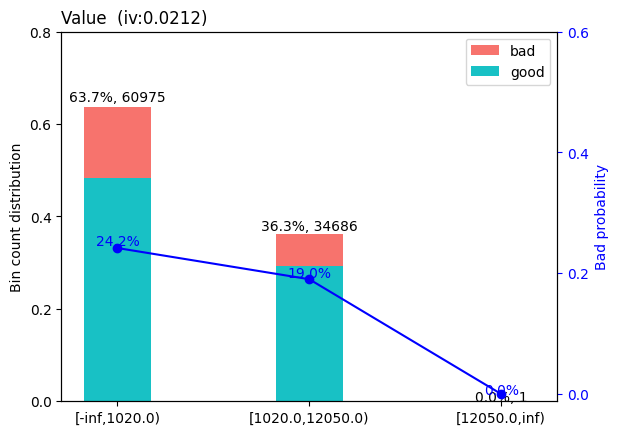

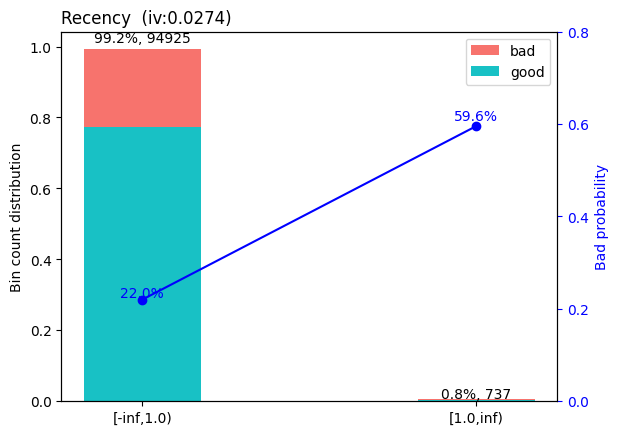

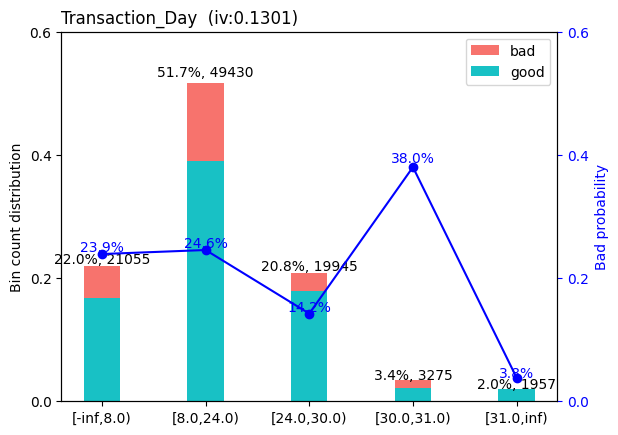

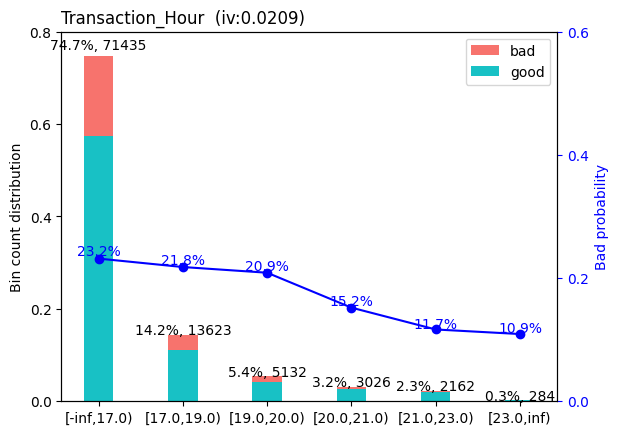

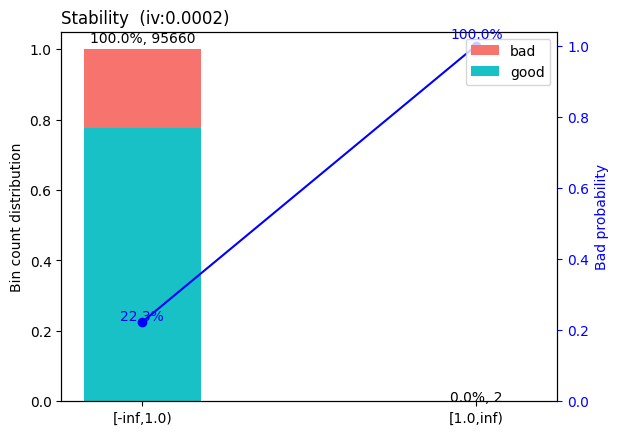

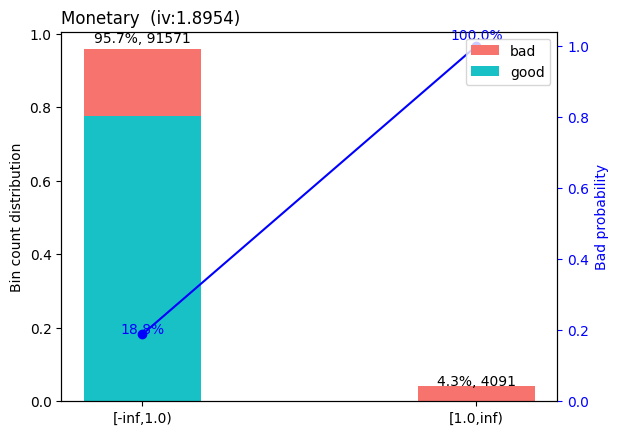

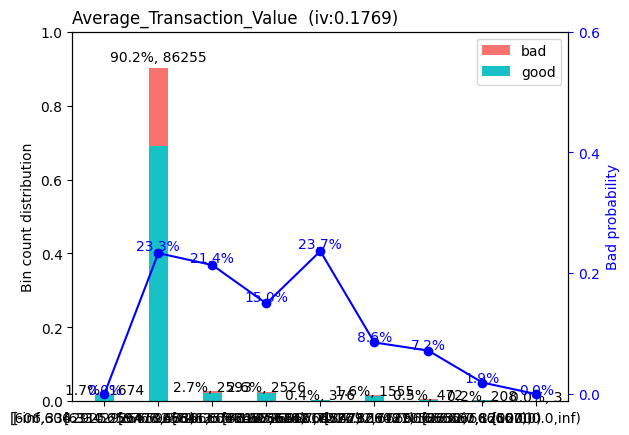

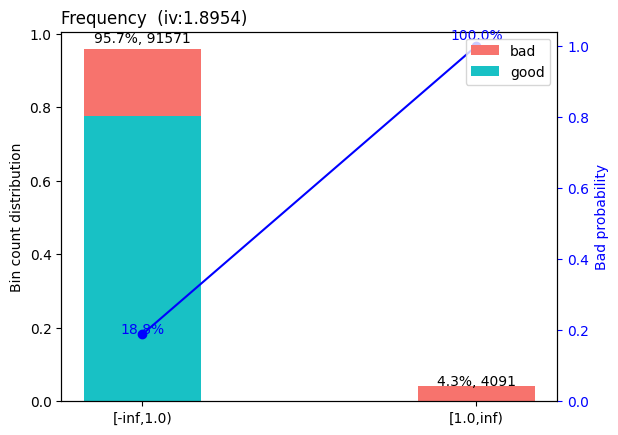

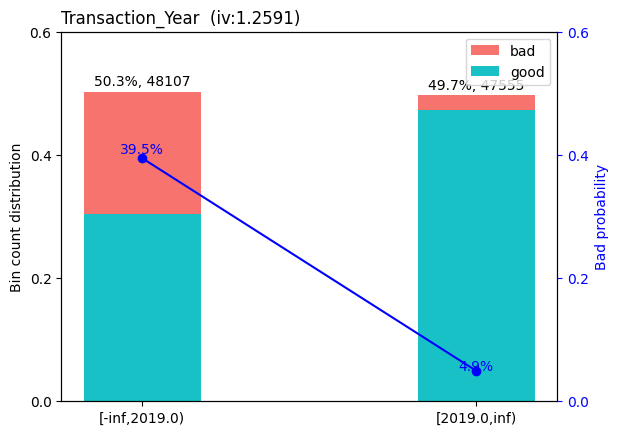

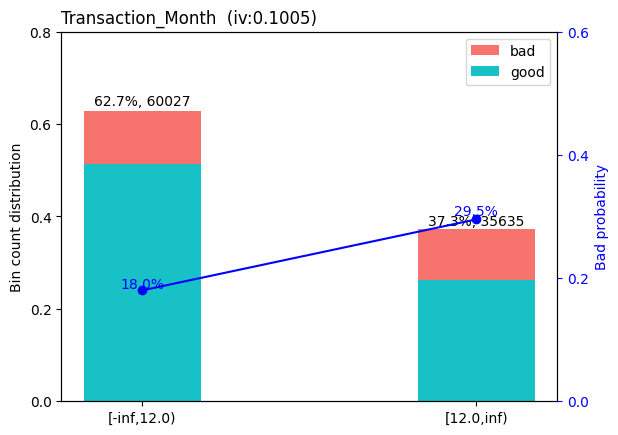

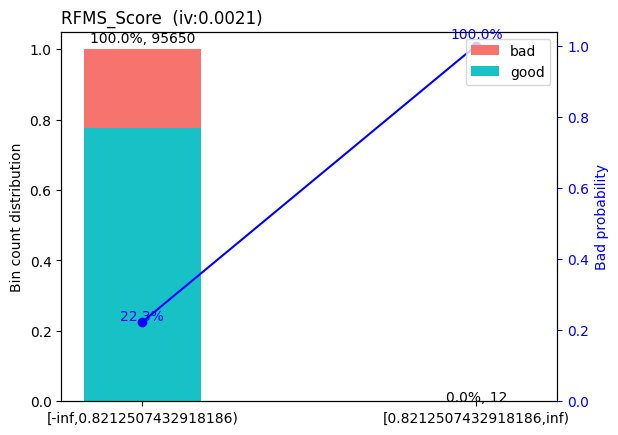

In [18]:
## create WOE Plots
sc.woebin_plot(bins_adj)

In [19]:
# converting df into woe values
df_woe = sc.woebin_ply(df, bins_adj)

[INFO] converting into woe values ...


In [20]:
df_woe.head()

,Cluster,Value_woe,Recency_woe,Transaction_Day_woe,Transaction_Hour_woe,Stability_woe,Monetary_woe,Average_Transaction_Value_woe,Frequency_woe,Transaction_Year_woe,Transaction_Month_woe,RFMS_Score_woe
0,0,0.105123,1.635833,0.125989,0.049337,-0.000082,-0.212928,0.059461,-0.212928,0.820147,-0.267679,-0.000551
1,0,0.105123,1.635833,0.125989,0.049337,-0.000082,-0.212928,0.059461,-0.212928,0.820147,-0.267679,-0.000551
2,1,0.105123,1.635833,0.125989,0.049337,-0.000082,-0.212928,-6.279989,-0.212928,0.820147,-0.267679,-0.000551
3,0,0.105123,1.635833,0.125989,0.049337,-0.000082,-0.212928,0.059461,-0.212928,0.820147,-0.267679,-0.000551
4,0,0.105123,1.635833,0.125989,0.049337,-0.000082,-0.212928,0.059461,-0.212928,0.820147,-0.267679,-0.000551


In [21]:
## Merge with df
# Merge by index
df_merged = df.merge(df_woe, how = 'left', left_index=True, right_index=True)

In [22]:
## Drop unwanted columns and rename
df_merged = df_merged.drop(columns='Cluster_x').rename(columns={'Cluster_y':'BAD'})

In [23]:
df_merged.head()

,Value,Transaction_Hour,Transaction_Day,Transaction_Month,Transaction_Year,Average_Transaction_Value,Recency,Frequency,Monetary,Stability,RFMS_Score,BAD,Value_woe,Recency_woe,Transaction_Day_woe,Transaction_Hour_woe,Stability_woe,Monetary_woe,Average_Transaction_Value_woe,Frequency_woe,Transaction_Year_woe,Transaction_Month_woe,RFMS_Score_woe
0,1000.0,2,15,11,2018,1553.336134,1.0,0.028851,0.026998,0.277278,0.333282,0,0.105123,1.635833,0.125989,0.049337,-0.000082,-0.212928,0.059461,-0.212928,0.820147,-0.267679,-0.000551
1,20.0,2,15,11,2018,1553.336134,1.0,0.028851,0.026998,0.277278,0.333282,0,0.105123,1.635833,0.125989,0.049337,-0.000082,-0.212928,0.059461,-0.212928,0.820147,-0.267679,-0.000551
2,500.0,2,15,11,2018,500.000000,1.0,0.000244,0.000139,0.000000,0.250096,1,0.105123,1.635833,0.125989,0.049337,-0.000082,-0.212928,-6.279989,-0.212928,0.820147,-0.267679,-0.000551
3,1000.0,3,15,11,2018,3092.710526,1.0,0.009046,0.017162,0.483036,0.377311,0,0.105123,1.635833,0.125989,0.049337,-0.000082,-0.212928,0.059461,-0.212928,0.820147,-0.267679,-0.000551
4,644.0,3,15,11,2018,3092.710526,1.0,0.009046,0.017162,0.483036,0.377311,0,0.105123,1.635833,0.125989,0.049337,-0.000082,-0.212928,0.059461,-0.212928,0.820147,-0.267679,-0.000551


In [24]:
# This function calculates information value (IV) for multiple x variables
sc.iv(df_merged, y = 'BAD')

,variable,info_value
1,Monetary,5.702423
4,Average_Transaction_Value,5.673932
16,Stability,5.670583
10,Recency,4.606395
3,Frequency,4.515268
21,RFMS_Score,3.538079
12,Transaction_Month,2.915189
18,Frequency_woe,1.895448
2,Monetary_woe,1.895448
5,Transaction_Year_woe,1.259140


In [25]:
## retain only the most relevant and meaningful predictors for further analysis or model building.
final_df = sc.var_filter(df_merged, y = 'BAD')

[INFO] filtering variables ...


In [28]:
## Export the data
final_df.to_csv('woe_data.csv',index=False )